This tutorial can be downloaded [link](https://github.com/west-code-development/West/raw/master/Doc/tutorials/basic/basic_011.ipynb).

# Intro Tutorial 11: Computing Absorption Spectra Using Time-Dependent Density Functional Theory (TDDFT)

This tutorial shows how to compute the absorption spectrum of the ethene (C$_2$H$_4$) molecule using linear-response time-dependent density functional theory (TDDFT) within the Tamm-Dancoff approximation. WEST implements two distinct methods to compute the absorption spectrum:

* the Davidson approach, which iteratively diagonalizes the Liouville superoperator and uses its eigenvalues and eigenvectors to calculate the absorption spectrum;
* the Lanczos approach, which computes an effective tri-diagonalization of the Liouville superoperator and uses its resolvent to calculate the absorption spectrum over a broad energy range.

More details about the TDDFT implementation in WEST can be found in [Y. Jin, V. Yu, M. Govoni, A. Xu, and G. Galli, J. Chem. Theory Comput. 19, 8689–8705 (2023)](https://doi.org/10.1021/acs.jctc.3c00986).

In this tutorial, the TDDFT calculations are conducted using the semi-local PBE functional. See [Tutorial 10](https://github.com/west-code-development/West/raw/master/Doc/tutorials/basic/basic_010.ipynb) for TDDFT calculations using hybrid functionals.

## Step 1: Mean-field starting point

We first perform the DFT calculation using the [Quantum ESPRESSO](https://www.quantum-espresso.org/) code.

Download the following files to your working directory:

In [ ]:
%%bash
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/C_ONCV_PBE-1.2.upf
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/H_ONCV_PBE-1.2.upf
wget -N -q https://west-code.org/doc/training/C2H4/pw.in

We can inspect the `pw.in` file, the input for the `pw.x` code:

In [1]:
%%bash
cat pw.in

&control
calculation = 'scf'
pseudo_dir  = './'
/
&system
ibrav           = 1
celldm(1)       = 30.0
nat             = 6
ntyp            = 2
ecutwfc         = 25.0
nbnd            = 50
assume_isolated = 'mp'
/
&electrons
diago_full_acc = .TRUE.
/
ATOMIC_SPECIES
C  12.011   C_ONCV_PBE-1.2.upf
H  1.00784  H_ONCV_PBE-1.2.upf
ATOMIC_POSITIONS angstrom
C  6.842010  7.500000  7.500000
H  6.261924  6.560696  7.500000
H  6.261924  8.439284  7.500000
C  8.180848  7.500000  7.500000
H  8.761131  6.560806  7.500000
H  8.761131  8.439200  7.500000
K_POINTS gamma


We run `pw.x` on 2 cores.

In [ ]:
%%bash
mpirun -n 2 pw.x -i pw.in > pw.out

## Step 2: Calculation of absorption spectrum using the Davidson method

We run the `wbse.x` executable to compute the excitation energies of the low-lying excited states of C$_2$H$_4$. Download the following file to your working directory:

In [ ]:
%%bash
wget -N -q https://west-code.org/doc/training/C2H4/davidson_wbse.in

Let us inspect the `davidson_wbse.in` file:

In [2]:
%%bash
cat davidson_wbse.in

input_west:
  qe_prefix: pwscf
  west_prefix: davidson
  outdir: ./

wbse_init_control:
  wbse_init_calculation: S
  solver: TDDFT

wbse_control:
  wbse_calculation: D
  n_liouville_eigen: 100
  n_liouville_maxiter: 1000
  trev_liouville: 0.000001
  trev_liouville_rel: 0.0001
  l_preconditioning: True
  l_pre_shift: True


The `wbse_calculation: D` keyword instructs the code to diagonalize the Liouville superoperator using the Davidson method, obtaining the leading eigenvalues and eigenvectors. The `n_liouville_eigen: 100` keyword specifies that the first 100 eigenvalues are computed.

We run `wbse.x` on 2 cores:

In [ ]:
%%bash
mpirun -n 2 wbse.x -i davidson_wbse.in > davidson_wbse.out

We run the `westpp.x` executable to compute the transition dipole moments (TDMs) of the low-lying excited states of C$_2$H$_4$. Download the following file to your working directory:

In [ ]:
%%bash
wget -N -q https://west-code.org/doc/training/C2H4/davidson_westpp.in

Let us inspect the `davidson_westpp.in` file:

In [3]:
%%bash
cat davidson_westpp.in

input_west:
   qe_prefix: pwscf
   west_prefix: davidson
   outdir: ./

westpp_control:
   westpp_calculation: C
   westpp_n_liouville_to_use: 100
   westpp_range: [1, 50]
   westpp_l_compute_tdm: True


The `westpp_calculation: C` keyword instructs the code to decompose the leading eigenvectors in terms of pairs of occupied and empty Kohn-Sham orbitals. The `westpp_n_liouville_to_use: 100` and `westpp_l_compute_tdm: True` keywords specify that the TDMs of the first 100 low-lying excited states are computed.

We run `westpp.x` on 2 cores:

In [ ]:
%%bash
mpirun -n 2 westpp.x -i davidson_westpp.in > davidson_westpp.out

The output can be found in the file `davidson.westpp.save/westpp.json`. If the reader does NOT have the computational resources to run the calculations, the output file can be directly downloaded as:

In [ ]:
%%bash
mkdir -p davidson.westpp.save
wget -N -q https://west-code.org/doc/training/C2H4/westpp.json -O davidson.westpp.save/westpp.json

We use the [WESTpy Python package](https://west-code.org/doc/westpy/latest/) to parse this file and plot the absorption coefficient as a function of the photon frequency.

 
 _    _ _____ _____ _____            
| |  | |  ___/  ___|_   _|           
| |  | | |__ \ `--.  | |_ __  _   _  
| |/\| |  __| `--. \ | | '_ \| | | | 
\  /\  / |___/\__/ / | | |_) | |_| | 
 \/  \/\____/\____/  \_/ .__/ \__, | 
                       | |     __/ | 
                       |_|    |___/  
 
WEST version     :  5.5.0
Today            :  2024-02-01 15:10:57.307555
plotting absorption spectrum (Davidson)
output written in :  davidson_XYZ.png
waiting for user to close image preview...


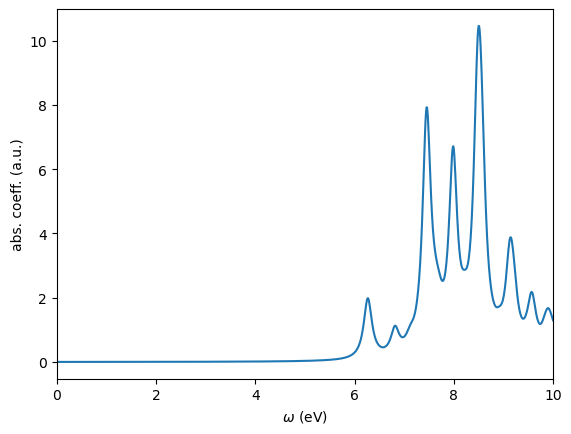

In [4]:
from westpy.bse import *

davidson_result = BSEResult("davidson.westpp.save/westpp.json")
davidson_result.plotSpectrum(ipol="XYZ",energyRange=[0.0,10.0,0.01],sigma=0.1,fname="davidson_XYZ.png")

## Step 3: Calculation of absorption spectrum using the Lanczos method

We run the `wbse.x` executable to compute the absorption spectrum of C$_2$H$_4$ using the Lanczos method. Download the following file to your working directory:

In [ ]:
%%bash
wget -N -q https://west-code.org/doc/training/C2H4/lanczos_wbse.in

Let us inspect the `lanczos_wbse.in` file:

In [5]:
%%bash
cat lanczos_wbse.in

input_west:
  qe_prefix: pwscf
  west_prefix: lanczos
  outdir: ./

wbse_init_control:
  wbse_init_calculation: S
  solver: TDDFT

wbse_control:
  wbse_calculation: L
  wbse_ipol: XYZ
  n_lanczos: 3000
  n_steps_write_restart: -1


The `wbse_calculation: L` keyword instructs the code to compute the absorption spectrum using the Lanczos algorithm. The `wbse_ipol: XYZ` keyword specifies which components of the polarizability tensor are computed, where `XYZ` means that three Lanczos chains are sequentially performed to compute the full polarizability tensor.

We run `wbse.x` on 2 cores:

In [ ]:
%%bash
mpirun -n 2 wbse.x -i lanczos_wbse.in > lanczos_wbse.out

The output can be found in the file `lanczos.wbse.save/wbse.json`. If the reader does NOT have the computational resources to run the calculations, the output file can be directly downloaded as:

In [ ]:
%%bash
mkdir -p lanczos.wbse.save
wget -N -q https://west-code.org/doc/training/C2H4/wbse.json -O lanczos.wbse.save/wbse.json

We use WESTpy to parse this file and plot the absorption coefficient as a function of the photon frequency.

plotting absorption spectrum (Lanczos)
output written in :  lanczos_XYZ.png
waiting for user to close image preview...


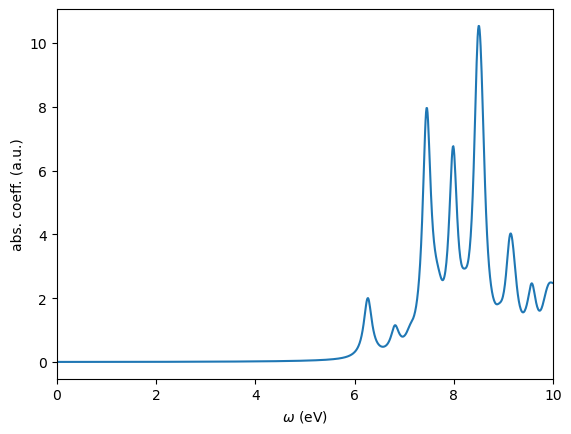

In [6]:
lanczos_result = BSEResult("lanczos.wbse.save/wbse.json")
lanczos_result.plotSpectrum(ipol="XYZ",energyRange=[0.0,10.0,0.01],sigma=0.1,n_extra=97000,fname="lanczos_XYZ.png")

The spectra computed with the Davidson and Lanczos methods closely align with each other, as anticipated. Although the two methods are theoretically expected to produce identical absorption spectra, each has its unique advantages and disadvantages.

* The Davidson approach is particularly beneficial when it's necessary to explicitly determine the eigenvalues and eigenvectors of a few low-lying excited states, such as in the analysis of excited state potential energy surfaces. This method is also capable of identifying "dark" excited states, which are dipole forbidden. However, its application is less suited for studying the absorption spectrum over a broad energy range in large systems due to the significant computational demands associated with computing a large number of eigenvalues and eigenvectors of the Liouville superoperator.

* Conversely, the Lanczos approach excels in computing the absorption spectrum for large systems across a wide energy range. However, it does not provide direct insights into the composition of excited states.

Users should choose the appropriate method based on their specific requirements and the nature of the system under study.